# Imports

In [64]:
import os
import sys
import zipfile

import seaborn as sns
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm

In [10]:
PROJECT_PATH = '/Users/alexanderbaranof/Documents/dailydialog-topic-recommendations/'

In [11]:
sys.path.append(os.path.join(PROJECT_PATH, 'src'))

In [12]:
from data.utils import download

# Methods

# Constants

In [19]:
CORPUS_NAME = 'ijcnlp_dailydialog'
CORPUS_ZIP = 'ijcnlp_dailydialog.zip'

# Checking data

In [18]:
# checking that directory exist 
corpus_dir = os.path.join(PROJECT_PATH, os.path.join('data/raw/', CORPUS_NAME))
print(corpus_dir)

/Users/alexanderbaranof/Documents/dailydialog-topic-recommendations/data/raw/ijcnlp_dailydialog


In [20]:
corpus_zip_dir = os.path.join(PROJECT_PATH, os.path.join('data/raw/', CORPUS_ZIP))
print(corpus_zip_dir)

/Users/alexanderbaranof/Documents/dailydialog-topic-recommendations/data/raw/ijcnlp_dailydialog.zip


In [27]:
if os.path.exists(corpus_dir):
    print('Corpus is aviable!')
else:
    if os.path.exists(corpus_zip_dir):
        print('Only zip file aviable!')
        with zipfile.ZipFile(corpus_zip_dir, 'r') as zip_ref:
            zip_ref.extractall('../data/raw/')
        print('Unziped!')
    else:
        download(url='http://yanran.li/files/ijcnlp_dailydialog.zip',
                 file_name='../data/raw/ijcnlp_dailydialog.zip')
        with zipfile.ZipFile(corpus_zip_dir, 'r') as zip_ref:
            zip_ref.extractall('../data/raw/')
        print('Unziped!')

Corpus is aviable!


# Lets do EDA

In [29]:
corpus = open(os.path.join(corpus_dir, 'dialogues_text.txt'), 'r')
corpus = corpus.read()
corpus = corpus.split('\n')

In [34]:
print('Corpus len is', len(corpus))

Corpus len is 13119


In [35]:
corpus[0]

"The kitchen stinks . __eou__ I'll throw out the garbage . __eou__"

In [36]:
corpus = [dialog.split('__eou__') for dialog in corpus]

In [37]:
corpus[0]

['The kitchen stinks . ', " I'll throw out the garbage . ", '']

## One of the tasks is to create a stop list of noun chunks phrases

In [ ]:
!python3.7 -m spacy download en_core_web_sm

In [44]:
parser = spacy.load('en_core_web_sm')

In [47]:
noun_chunks = list()

for dialog in tqdm(corpus):
    for phrase in dialog:
        document = parser(phrase)
        for nc in document.noun_chunks:
            noun_chunks.append(nc)

100%|██████████| 13119/13119 [08:06<00:00, 26.96it/s]


In [48]:
noun_chunks[:4]

[I, the garbage, So Dick, some coffee]

In [50]:
print(len(noun_chunks))

340685


In [57]:
# apply lower-case as a simple preprocessing
noun_chunks = [nc.text.lower() for nc in noun_chunks]

In [58]:
noun_chunks = pd.Series(noun_chunks)

In [62]:
df_nc = pd.DataFrame(noun_chunks.value_counts())
df_nc = df_nc.rename(columns={0:'word_count'})

In [63]:
df_nc

,word_count
i,52433
you,47824
it,23881
we,9948
me,8298
...,...
aristocratic women,1
s m i t h,1
judgement,1
so many shops,1


In [82]:
print('quantile:')
print('0.90', df_nc['word_count'].quantile(q=0.90))
print('0.15', df_nc['word_count'].quantile(q=0.15))

quantile:
0.90 5.0
0.15 1.0


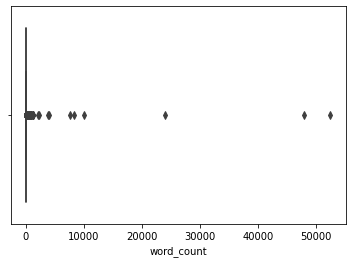

In [83]:
ax = sns.boxplot(x=df_nc["word_count"])

In [85]:
sdf_nc = df_nc[(df_nc.word_count < 5)&(df_nc.word_count > 1)]

In [86]:
len(sdf_nc)

16109

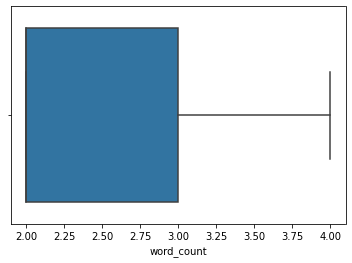

In [87]:
ax = sns.boxplot(x=sdf_nc["word_count"])

Such data is much better

But we need a stop list

In [91]:
bdf_nc = df_nc[(df_nc.word_count  >= 5)|(df_nc.word_count <= 1)]

In [93]:
bdf_nc = bdf_nc.reset_index(drop=False)

In [94]:
bdf_nc.head(5)

,index,word_count
0,i,52433
1,you,47824
2,it,23881
3,we,9948
4,me,8298


In [95]:
bdf_nc.tail(5)

,index,word_count
37430,aristocratic women,1
37431,s m i t h,1
37432,judgement,1
37433,so many shops,1
37434,three thousand yuan,1


In [96]:
# save te result
bdf_nc.to_csv('../data/processed/stoplist.csv')